# 1. 数据导入

In [80]:
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset, TensorDataset
import numpy as np
%matplotlib inline

In [81]:
basic = os.getcwd()
save_path = basic + "/bilstm_params.pkl"
data_path = basic + "/data_x.pickle"
label_path = basic + "/data_y.pickle"

In [82]:
data = pickle.load(open(data_path, "rb"))
label = pickle.load(open(label_path, "rb")).reshape(37)

In [83]:
# Hyper Parameters
EPOCH = 10               # train the training data n times
BATCH_SIZE = 8
HIDDEN_SIZE = 16
TIME_STEP = data.shape[1]         # rnn time step / image height
INPUT_SIZE = data.shape[2]         # rnn input size / image width
LR = 0.01               # learning rate

In [84]:
train_x, valid_x, train_y, valid_y = train_test_split(data, label, train_size=0.8, random_state=100)
train_x.shape

(29, 10, 7)

# 2. 模型训练

In [85]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset, TensorDataset

In [86]:
torch.manual_seed(999)    # reproducible

In [87]:
# Data Loader for easy mini-batch return in training
train_x, train_y = torch.from_numpy(train_x), torch.from_numpy(train_y)
valid_x, valid_y = torch.from_numpy(valid_x), torch.from_numpy(valid_y)
train_loader = torch.utils.data.DataLoader(dataset=TensorDataset(train_x, train_y), 
                                           batch_size=BATCH_SIZE, shuffle=True)

In [122]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BiRNN(nn.Module):
    
    def __init__(self, hidden_size=HIDDEN_SIZE, num_layers=3, num_classes=2):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(INPUT_SIZE, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
        self.hidden = None
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, self.hidden = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [139]:
rnn = BiRNN()
print(rnn)

BiRNN(
  (lstm): LSTM(7, 16, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


In [140]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all rnn parameters
loss_func = nn.CrossEntropyLoss()

Epoch:  0 | train loss: 0.5344 | valid loss: 0.8641 | train accuracy: 0.6897 | valid accuracy: 0.3750
Epoch:  1 | train loss: 0.4067 | valid loss: 0.7235 | train accuracy: 0.7586 | valid accuracy: 0.5000
Epoch:  2 | train loss: 0.5190 | valid loss: 0.8763 | train accuracy: 0.8966 | valid accuracy: 0.5000
Epoch:  3 | train loss: 0.3251 | valid loss: 1.0498 | train accuracy: 0.8621 | valid accuracy: 0.5000
Epoch:  4 | train loss: 0.5745 | valid loss: 0.9523 | train accuracy: 0.8276 | valid accuracy: 0.5000
Epoch:  5 | train loss: 0.2135 | valid loss: 1.1462 | train accuracy: 0.8966 | valid accuracy: 0.5000
Epoch:  6 | train loss: 0.4373 | valid loss: 1.2311 | train accuracy: 0.8966 | valid accuracy: 0.5000
Epoch:  7 | train loss: 0.2330 | valid loss: 1.1564 | train accuracy: 0.8276 | valid accuracy: 0.6250
Epoch:  8 | train loss: 0.4369 | valid loss: 1.0266 | train accuracy: 0.7931 | valid accuracy: 0.6250
Epoch:  9 | train loss: 0.2417 | valid loss: 1.0119 | train accuracy: 0.9310 | val

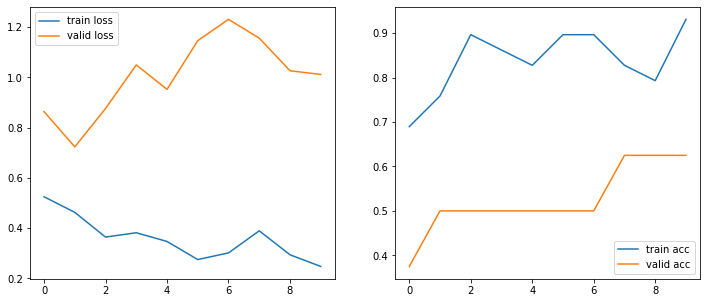

In [147]:
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.float())                       # batch x
        b_y = Variable(y.long())                        # batch y
        output = rnn(b_x)                            # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients
        if step % 5 == 0:
            valid_output = rnn(Variable(valid_x.float()))
            train_output = rnn(Variable(train_x.float()))
            train_loss = loss_func(train_output, train_y.long())
            valid_loss = loss_func(valid_output, valid_y.long())
            train_losses.append(train_loss.data)
            valid_losses.append(valid_loss.data)
            
            pred_train = torch.max(train_output, 1)[1].data.numpy().squeeze()
            pred_valid = torch.max(valid_output, 1)[1].data.numpy().squeeze()
            train_accu = sum(pred_train == train_y.data.numpy()) / float(train_y.numpy().size)
            valid_accu = sum(pred_valid == valid_y.data.numpy()) / float(valid_y.numpy().size)
            train_accuracy.append(train_accu)
            valid_accuracy.append(valid_accu)
            
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| valid loss: %.4f' % valid_loss.data, 
                  '| train accuracy: %.4f' % train_accu, '| valid accuracy: %.4f' % valid_accu)

ax1.plot(train_losses, label="train loss")
ax1.plot(valid_losses, label="valid loss")
ax1.legend()
ax2.plot(train_accuracy, label="train acc")
ax2.plot(valid_accuracy, label="valid acc")
ax2.legend()

BiRNN(
  (lstm): LSTM(7, 16, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


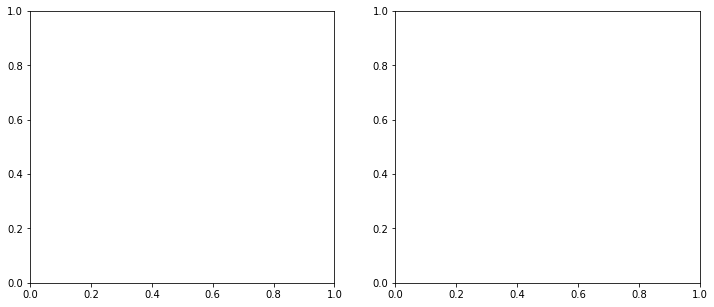

In [148]:
rnn1 = BiRNN()
print(rnn1)
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

# training and testing
for epoch in range(EPOCH):
    data1 = torch.tensor(data)
    y1 = torch.tensor(label)
    b_x = Variable(data1.float())                       # batch x
    b_y = Variable(y1.long())                        # batch y
    output = rnn1(b_x)                            # rnn output
    loss = loss_func(output, b_y)                   # cross entropy loss
    optimizer.zero_grad()                           # clear gradients for this training step
    loss.backward()                                 # backpropagation, compute gradients
    optimizer.step()                                # apply gradients
#     if step % 5 == 0:
#         valid_output = rnn(Variable(valid_x.float()))
#         train_output = rnn(Variable(train_x.float()))
#         train_loss = loss_func(train_output, train_y.long())
#         valid_loss = loss_func(valid_output, valid_y.long())
#         train_losses.append(train_loss.data)
#         valid_losses.append(valid_loss.data)

#         pred_train = torch.max(train_output, 1)[1].data.numpy().squeeze()
#         pred_valid = torch.max(valid_output, 1)[1].data.numpy().squeeze()
#         train_accu = sum(pred_train == train_y.data.numpy()) / float(train_y.numpy().size)
#         valid_accu = sum(pred_valid == valid_y.data.numpy()) / float(valid_y.numpy().size)
#         train_accuracy.append(train_accu)
#         valid_accuracy.append(valid_accu)

#         print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| valid loss: %.4f' % valid_loss.data, 
#               '| train accuracy: %.4f' % train_accu, '| valid accuracy: %.4f' % valid_accu)

# ax1.plot(train_losses, label="train loss")
# ax1.plot(valid_losses, label="valid loss")
# ax1.legend()
# ax2.plot(train_accuracy, label="train acc")
# ax2.plot(valid_accuracy, label="valid acc")
# ax2.legend()

In [118]:
# print 10 predictions from test data
valid_output = rnn(Variable(valid_x.float()))
pred_y = torch.max(valid_output, 1)[1].data.numpy().squeeze()
pred_y[:10], valid_y[:10]

(array([1, 0, 1, 1, 1, 1, 1, 0]),
 tensor([1., 0., 1., 1., 0., 1., 1., 0.], dtype=torch.float64))

In [39]:
torch.save(rnn, save_path)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BiRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [75]:
print(output)

tensor([[-0.5949,  0.3043],
        [ 0.8917, -0.7752],
        [ 0.1438, -0.1551],
        [ 0.9887, -0.9103],
        [-0.7705,  0.5094]], grad_fn=<AddmmBackward>)


In [108]:
print(valid_output)

tensor([[-0.4744,  0.7503],
        [-0.4493,  0.8030],
        [-0.2952,  0.5580],
        [ 0.4589, -0.5202],
        [-0.4861,  0.8510],
        [-0.5169,  0.8508],
        [-0.5139,  0.8725],
        [ 0.6443, -0.7716]], grad_fn=<AddmmBackward>)


In [111]:
print(torch.max(valid_output, 1))

torch.return_types.max(
values=tensor([0.7503, 0.8030, 0.5580, 0.4589, 0.8510, 0.8508, 0.8725, 0.6443],
       grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 1, 0, 1, 1, 1, 0]))


In [149]:
rnn1.hidden[1].shape

torch.Size([6, 37, 16])

In [150]:
rnn1.hidden[0].shape

torch.Size([6, 37, 16])

In [151]:
rnn1.hidden[1]

tensor([[[-1.0000e+01,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           1.0650e+00,  1.0000e+00],
         [-8.0000e+00,  1.8059e-26,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [-1.0000e+01,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -1.7160e-01,  1.0000e+01],
         ...,
         [-1.0000e+01,  8.0425e-28,  0.0000e+00,  ...,  0.0000e+00,
          -1.0000e+00,  9.9018e+00],
         [-6.2466e+00,  0.0000e+00,  0.0000e+00,  ...,  1.4818e-01,
          -1.4552e+00,  6.1519e+00],
         [-1.0000e+01,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -8.0000e+00,  1.0000e+01]],

        [[ 3.4865e-09,  1.0000e+00,  2.0000e+00,  ..., -9.0000e+00,
          -1.0000e+00,  0.0000e+00],
         [ 2.0266e-10, -1.0000e+00,  9.9754e-01,  ..., -4.0000e+00,
          -1.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -1.0000e+00,  4.0236e-09,  ..., -1.0000e+01,
          -1.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  1